In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.constants import c

# --- 1. Define Radar and Target Parameters ---

# Radar system parameters
fc = 5.5e9  # Carrier frequency: 3 GHz
T = 5e-6  # Pulse duration: 5 microseconds
B = 2.5e6  # Bandwidth: 10 MHz
fs = 2 * B  # Sampling frequency: 20 MHz (must be >= 2*B)
# calculate TBP
TBP = B * T  # Time-Bandwidth Product
print(f'Time-Bandwidth Product (TBP): {TBP}')
N_l=50
PRI = N_l* T  # Pulse Repetition Interval: 50 pulses
t = np.arange(0, PRI, 1/fs)  # Time vector for one pulse

# Target parameters (two targets with different properties)
# Target 1
R1 = 5000  # Range: 5 km
v1 = 50   # Speed: 50 m/s
rcs1 = 0.1 # Radar Cross-Section: 100 m^2

# Target 2
R2 = 5400  # Range: 8 km
v2 = -30  # Speed: -30 m/s (moving towards the radar)
rcs2 = 0.1 # Radar Cross-Section: 50 m^2

# --- 2. Generate the Transmitted LFM Signal ---

# LFM chirp signal
k = B / T  # Chirp rate
tx_signal = np.exp(1j * 2 * np.pi * (fc * t + 0.5 * k * t**2))

# --- 3. Simulate Received Signals for Each Target ---

# Define the radar equation-based attenuation factor
# Simplified model, proportional to sqrt(RCS) / R^2
def get_attenuation(R, rcs):
    return np.sqrt(rcs)

# Simulate reception for target 1
def get_target_signal(t, R, v, rcs, pulse_number, PRI):
    tau = 2 * (R+t+pulse_number * PRI) / c  # Time delay for the target
    fd = -2 * v * fc / c  # Doppler frequency shift
    atten = get_attenuation(R, rcs)
    t_delayed = t - tau
    # Create a delayed and Doppler-shifted version of the transmitted signal
    rx_signal = atten * np.exp(1j * 2 * np.pi * (fc * (t_delayed) + 0.5 * k * (t_delayed)**2 + fd * t ))* np.exp(1j * 2 * np.pi * fd*(pulse_number * PRI))  # Add pulse number phase shift
    # Set the signal to zero for times before the signal arrives
    rx_signal[t < tau] = 0
    rx_signal[t > tau + T] = 0  # Ensure no signal after the pulse duration
    return rx_signal

def noise_signal(t, noise_level=0.1):
    """Generate white Gaussian noise."""
    return noise_level * (np.random.randn(len(t)) + 1j * np.random.randn(len(t)))
#tau1 = 2 * R1 / c  # Time delay for target 1
#fd1 = -2 * v1 * fc / c  # Doppler frequency shift for target 1
#atten1 = get_attenuation(R1, rcs1)
# Create a delayed and Doppler-shifted version of the transmitted signal
#t_delayed1 = t - tau1
#rx_signal1 = atten1 * np.exp(1j * 2 * np.pi * (fc * (t_delayed1) + 0.5 * k * (t_delayed1)**2 + fd1 * t))
# Set the signal to zero for times before the signal arrives
#rx_signal1[t < tau1] = 0
#rx_signal1[t > tau1 + T] = 0  # Ensure no signal after the pulse duration

rx_signal1 = get_target_signal(t, R1, v1, rcs1, 0, PRI)
rx_signal2 = get_target_signal(t, R2, v2, rcs2, 0, PRI)

# Simulate reception for target 2
#tau2 = 2 * R2 / c  # Time delay for target 2
#fd2 = -2 * v2 * fc / c  # Doppler frequency shift for target 2
#atten2 = get_attenuation(R2, rcs2)
# Create a delayed and Doppler-shifted version of the transmitted signal
#t_delayed2 = t - tau2
#rx_signal2 = atten2 * np.exp(1j * 2 * np.pi * (fc * (t_delayed2) + 0.5 * k * (t_delayed2)**2 + fd2 * t))
# Set the signal to zero for times before the signal arrives
#rx_signal2[t < tau2] = 0
#rx_signal2[t > tau2 + T] = 0  # Ensure no signal after the pulse duration

# --- 4. Combine the Signals from All Targets ---
noise= noise_signal(t, noise_level=0.1)  # Generate noise
rx_combined = rx_signal1 + rx_signal2+ noise  # Combine signals from both targets with noise


Time-Bandwidth Product (TBP): 12.500000000000002


In [ ]:
pulse_ind=np.nonzero(t<T)
matched_filter = np.conj(np.flip(tx_signal[pulse_ind]))  # Matched filter for LFM signal

import scipy
output2 = np.convolve(rx_combined, matched_filter, mode='same')
rad_range= c*t/2
nr=rad_range.shape[0]
output2 = scipy.signal.correlate(rx_combined, tx_signal[pulse_ind], mode='full')[-nr:]
reference_energy = np.mean(np.abs(rx_combined)**2)
output_energy = np.mean(np.abs(output2)**2)
print(f'Reference Energy: {reference_energy}, Output Energy: {output_energy}')

Reference Energy: 0.024727711920648383, Output Energy: 0.7316945736764588


(4000.0, 10000.0)

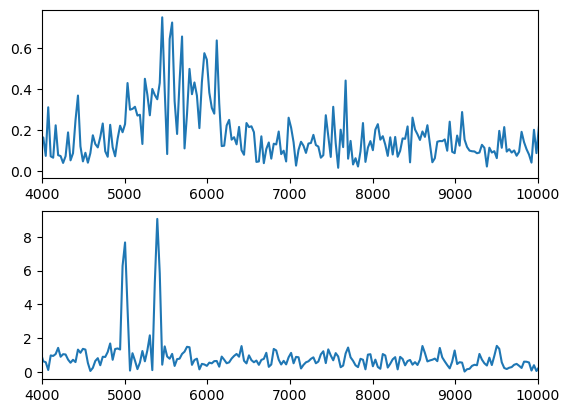

In [ ]:

plt.subplot(211)
plt.plot(rad_range,np.abs(rx_combined), label='Real Part')
plt.xlim(4000, 10000)
plt.subplot(212)
nr=rad_range.shape[0]
plt.plot(rad_range,np.abs(output2)[:nr], label='Compressed Signal')
plt.xlim(4000, 10000)



In [ ]:
energy_L=[]
rx_signal_batch=[]
for k in range(0,64):
    raw_signal = get_target_signal(t, R1, v1, rcs1, k, PRI) + 0.1 * noise_signal(t)
    compressed_signal = np.convolve(raw_signal, matched_filter, mode='full')[-nr:]
    rx_signal_batch.append(compressed_signal)

rx_signal_batch = np.array(rx_signal_batch)

# doppler processing



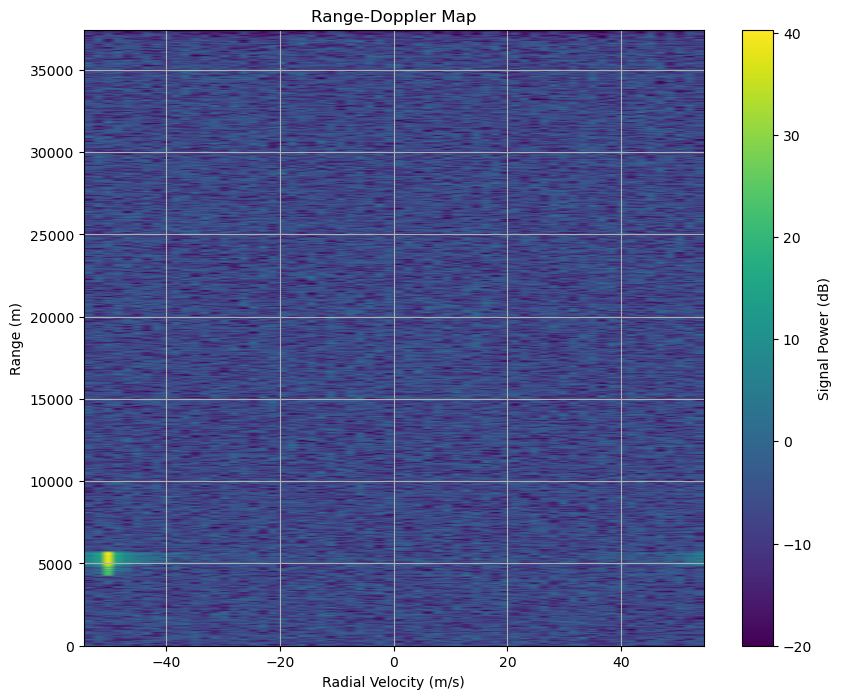

Detected Peak Velocity: 51.05 m/s
Detected Peak Range Bin: 186
Detected Peak Range: 5576.14 m


In [ ]:
# The FFT is applied to each range bin's time history
# We can do this efficiently using NumPy's FFT function along the correct axis
# We perform the FFT along axis 0 (the pulse dimension) of the range_pulse_matrix
# The result will be a (num_pulses, num_range_bins) matrix, so we'll need to reorient it
range_doppler_map = np.fft.fft(rx_signal_batch, axis=0)

# Shift the zero-frequency component to the center for a more intuitive plot
range_doppler_map = np.fft.fftshift(range_doppler_map, axes=0)

# --- Visualization ---
# Plotting the range-Doppler map to see the result
# We typically plot the magnitude (in dB) of the map

# Calculate the Doppler frequency axis
# The unambiguous Doppler frequency range is from -PRF/2 to +PRF/2
PRF = 1 / PRI
num_pulses = rx_signal_batch.shape[0]
doppler_freqs = np.linspace(-PRF / 2, PRF / 2, num_pulses)

# Convert Doppler frequency to velocity
# v = -f_d * c / (2 * fc)
doppler_velocities = -doppler_freqs * c / (2 * fc)

# Calculate the range axis
range_resolution = (c / (2 * (1e6 * 2)))  # Assuming a 2MHz bandwidth after compression, just for plotting
num_range_bins = rx_signal_batch.shape[1]
range_axis = rad_range

# Plot the result
plt.figure(figsize=(10, 8))
plt.imshow(10 * np.log10(np.abs(range_doppler_map.T)**2),
           extent=[doppler_velocities.min(), doppler_velocities.max(), range_axis.min(), range_axis.max()],
           aspect='auto', origin='lower',
           vmin=-20)  # Set a lower limit to see the noise floor better

plt.title('Range-Doppler Map')
plt.xlabel('Radial Velocity (m/s)')
plt.ylabel('Range (m)')
plt.colorbar(label='Signal Power (dB)')
plt.grid(True)
plt.show()

# --- Analysis of the Result ---

# Find the peak in the range-Doppler map
peak_power = np.max(np.abs(range_doppler_map)**2)
peak_indices = np.unravel_index(np.argmax(np.abs(range_doppler_map)**2), range_doppler_map.shape)
detected_doppler_bin = peak_indices[0]
detected_range_bin = peak_indices[1]

# Convert the peak indices back to physical units
detected_velocity = doppler_velocities[detected_doppler_bin]
detected_range = range_axis[detected_range_bin]

#print(f"Original Target Velocity: {target_velocity} m/s")
print(f"Detected Peak Velocity: {detected_velocity:.2f} m/s")
#print(f"Original Target Range Bin: {target_range_bin}")
print(f"Detected Peak Range Bin: {detected_range_bin}")
print(f"Detected Peak Range: {detected_range:.2f} m")

In [ ]:

# --- 5. Mix with Reference Signal (De-Chirp on Receive) ---
# Multiply the received signal by the complex conjugate of the transmitted signal
reference_signal = np.exp(-1j * 2 * np.pi * (fc * t + 0.5 * k * t**2))
mixed_signal = rx_combined * reference_signal

# --- 6. Perform FFT to Find Beat Frequencies ---
# Perform FFT on the mixed signal
NFFT = 2**12 # Use a power of 2 for efficient FFT computation
fft_out = np.fft.fft(mixed_signal, NFFT)
fft_out = np.fft.fftshift(fft_out)
freq_axis = np.fft.fftshift(np.fft.fftfreq(NFFT, 1/fs))

# --- 7. Analyze FFT Output to Extract Range and Velocity ---

# The beat frequency (fb) is related to range and velocity
# fb = fd + k * tau = (-2*v*fc/c) + (B/T) * (2*R/c)
# We can find the peaks in the FFT output
peaks, _ = signal.find_peaks(np.abs(fft_out), height=0.5 * np.max(np.abs(fft_out)))
peak_freqs = freq_axis[peaks]
